![](photos/0.1.png)
## Name: Brayan José Calderón Amorocho 
### C.C 1032502998

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display_javascript, display_html, display
import json
from scipy.stats import norm, multivariate_normal
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc


![](photos/1.1.png)

In [2]:
df_raw = pd.read_csv("data/diabetes.csv")

In [3]:
df_raw.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [4]:
X = df_raw[["Pregnancies","Glucose","BloodPressure","SkinThickness","Insulin","BMI","DiabetesPedigreeFunction","Age"]].copy()
Y = df_raw["Outcome"].copy()

![](photos/1.2.png)

In [5]:
x_train,x_test,y_train,y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

In [6]:
print(f"El tamaño del dataset utilizado para train es de {y_train.count()} y el tamaño para el test es de {y_test.count()}")

El tamaño del dataset utilizado para train es de 514 y el tamaño para el test es de 254


![](photos/1.png)

In [7]:
features = x_train.columns
features_params = dict()

In [8]:
for feature in features:
    df = pd.merge(x_train[feature],y_train,left_index=True, right_index=True ,how="inner")
    features_params[feature] = {
        0:{
            "mean":df[df["Outcome"]==0][feature].mean(),
            "var": df[df["Outcome"]==0][feature].var()
        },
        1:{
            "mean":df[df["Outcome"]==1][feature].mean(),
            "var": df[df["Outcome"]==1][feature].var()
        }}
    

In [9]:
#Descomentar si se quiere observar los parametros de estimación de cada feature (mean,variance)
#print(json.dumps(features_params, indent = 4))

![](photos/2.png)

In [10]:

global pred_glucose

def dist_normal(df,feature,discr):
    mean = df[feature][discr]["mean"]
    dev =  np.sqrt(df[feature][discr]["var"])
    dist = norm(mean,dev)
    return dist

def get_indicators(df):
    TP = df[(df["predict"]==df["Outcome"])]["predict"][df["predict"]==1].count()
    TN = df[(df["predict"]==df["Outcome"])]["predict"][df["predict"]==0].count()
    FP = df[(df["predict"]!=df["Outcome"])]["predict"][df["predict"]==1].count()
    FN = df[(df["predict"]!=df["Outcome"])]["predict"][df["predict"]==0].count()
    TOTAL  = df["predict"].count() 
    return TP,TN, FP, FN,TOTAL

    

for feature in features_params:
    #Con la media y la varianza creamos los objetos de la distribución normal para 0 y 1 
    #Funcion de probabilidad del Likelihood P(x|Ci)
    norm_0 = dist_normal(features_params,feature,0)  #Probalidad de los datos dada la clase 0
    norm_1 = dist_normal(features_params,feature,1)  #Probabilidad de los datos dada la clase 1
    
    
    #Creo un DF que tiene dos columnas en una columna el feature especifico y el outcome/label
    df_trueLabels = pd.merge(x_test[feature], y_test,left_index=True, right_index=True ,how="inner")
    
    
    #Creo un array con las probabilidades de las clases, es decir el total de una clase/total de ambas clases
    prob_class = np.array([len(y_train[y_train==Class])/len(y_train) for Class in y_train.unique()])  #Probabilidad de las clases
    
    #Obtengo la probabilidad de cada clase para los datos de cada feature
    scores = [df_trueLabels[feature].apply(norm_0.pdf)*prob_class[0], #Probabilidad de que salga 0 dados los datos X
              df_trueLabels[feature].apply(norm_1.pdf)*prob_class[1]] #Probabilidad de que salga 1 dados los datos X
    
    #La predicción se toma como aquella con la que se tenga mayor probabilidad
    predict = np.argmax(scores,axis = 0)
    #Agrego una nueva columna que se llama predicción con los valores anteriores
    df_trueLabels["predict"] = predict
    
    #Obtengo los valores indicadores del estimador
    TP,TN,FP,FN,n = get_indicators(df_trueLabels)
    #Y los guardo en el diccionario para una posterior comparación
    features_params[feature]["results"] = {
        "TP":TP,
        "TN":TN,
        "FP":FP,
        "FN":FN,
    }
    #Guardo los valores correspondientes al rendimiento del modelo
    features_params[feature]["measures"] = {
        "accuracy" : (TP+TN)/n,
        "recall" : TP/(FP+TP),
        "precision": TP/(TP+FP) if (TP+FP) > 0 else 0
    }
    
    if feature=="Glucose":
        pred_glucose = scores[1].copy()
        pred_glucose = np.array(pred_glucose)
    

In [11]:
data = {}
#Creo un Dataframe con la información necesaria para la comparación entre los modelos
for f in features_params:
  data[f] = [
       features_params[f][0]['mean'],
       features_params[f][0]['var'],
       features_params[f][1]['mean'],
       features_params[f][1]['var'],
       features_params[f]['results']['TP'],
       features_params[f]['results']['TN'],
       features_params[f]['results']['FP'],
       features_params[f]['results']['FN'],
       features_params[f]['measures']['accuracy'],
       features_params[f]['measures']['recall'],
       features_params[f]['measures']['precision']
  ]

results = pd.DataFrame.from_dict(data, orient='index',
                       columns=['mean_0', 'var_0', 'mean_1', 'var_1', 'TP', 'TN', 'FP', 'FN','accuracy', 'recall', 'precision'])

In [12]:
results

,mean_0,var_0,mean_1,var_1,TP,TN,FP,FN,accuracy,recall,precision
Pregnancies,3.304217,9.009892,4.653846,12.780068,29,149,19,57,0.700787,0.604167,0.604167
Glucose,109.734940,636.841918,142.384615,1110.713132,38,145,23,48,0.720472,0.622951,0.622951
BloodPressure,68.382530,314.520902,72.906593,330.726034,2,166,2,84,0.661417,0.500000,0.500000
SkinThickness,19.822289,213.246269,21.807692,288.531874,2,165,3,84,0.657480,0.400000,0.400000
Insulin,67.213855,8960.706394,101.170330,20767.457015,14,154,14,72,0.661417,0.500000,0.500000
BMI,30.138554,52.379778,35.310440,52.671548,19,149,19,67,0.661417,0.500000,0.500000
DiabetesPedigreeFunction,0.434973,0.096720,0.542621,0.147084,13,162,6,73,0.688976,0.684211,0.684211
Age,30.743976,128.710689,37.653846,123.652996,14,143,25,72,0.618110,0.358974,0.358974


### According to above chart we can see the best accuracy is obtained by Glucose Variable with 72% of accuracy


In [13]:
dist_p0 = norm(results["mean_0"]["Glucose"], np.sqrt(results["var_0"]["Glucose"]))
dist_p1 = norm(results["mean_1"]["Glucose"], np.sqrt(results["var_1"]["Glucose"]))

In [14]:
max_glucose = df_raw["Glucose"].max()
min_glucose = df_raw["Glucose"].min()
f_x = np.arange(min_glucose,max_glucose+100,(max_glucose+100-min_glucose)/1000)
prob_class = np.array([len(y_train[y_train == c])/len(y_train) for c in y_train.unique()])
f_y0 = [dist_p0.pdf(value)*prob_class[0] for value in f_x]
f_y1 = [dist_p1.pdf(value)*prob_class[1] for value in f_x]


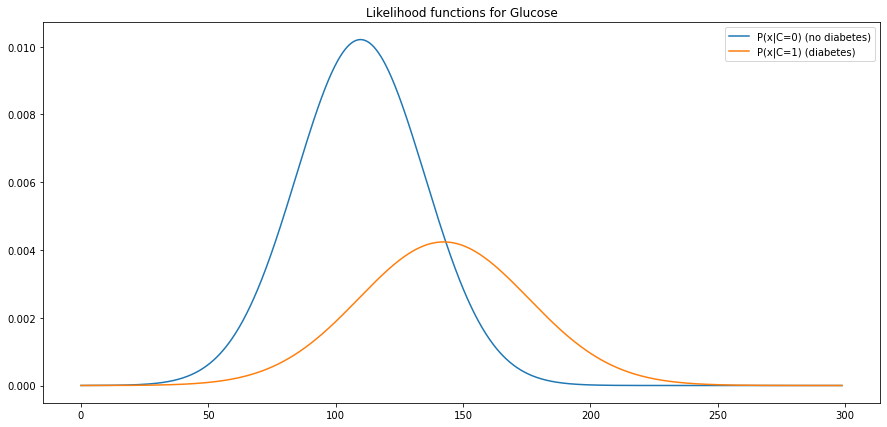

In [15]:
plt.figure(figsize = (15,7))
plt.title("Likelihood functions for Glucose")
plt.plot(f_x,f_y0,label='P(x|C=0) (no diabetes)')
plt.plot(f_x,f_y1,label='P(x|C=1) (diabetes)')
plt.legend()

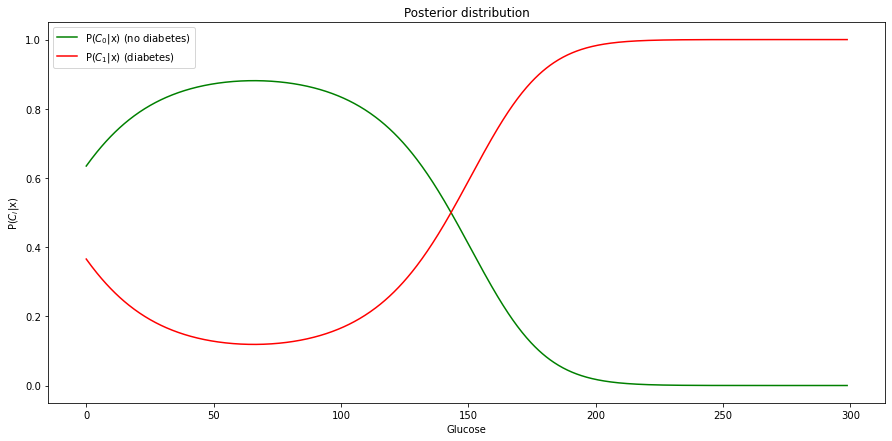

In [16]:
ty0=np.array(f_y0)/(np.array(f_y0) + np.array(f_y1))
ty1=np.array(f_y1)/(np.array(f_y0) + np.array(f_y1))
plt.figure(figsize = (15,7))
plt.plot(f_x, ty0, c='g',label='P($C_0$|x) (no diabetes)')
plt.plot(f_x, ty1, c='r',label='P($C_1$|x) (diabetes)')
plt.title('Posterior distribution')
plt.xlabel('Glucose')
plt.ylabel('P($C_i$|x)')
plt.legend()

![](photos/2.1.png)
![](photos/2.2.png)

To estimate $\sigma$ for each classificator, we use the next equation:
$$\mathbf{S}=\sum_i \hat{P}(C_i)\mathbf(S_i) \longrightarrow \sigma=\sum_i \hat{P}(C_i)\sigma_i$$

And for the discriminant we use a linear discriminant due the form of the covariance matrix:
$$g_i(x)=\sigma^{-1}[m_{i1} \ \ m_{i2}] \mathbf{x} -\frac{1}{2} [m_{i1} \ \ m_{i2}] \sigma^{-1} [m_{i1} \ \ m_{i2}]^T + log(P(c_i))$$


In [17]:
def covar_matrix(x,feature0,feature1):
    features = [feature0,feature1]
    mu = np.mean(x[features]).values
    cov0 = np.var(x[feature0])
    cov1 = np.var(x[feature1])
    covar = np.array([ [cov0,0],
                       [0,cov1] ])
    return mu,covar

In [18]:
def fit_model(x,y,feature0,feature1):
    features = [feature0,feature1]
    k = 2 #Numero de clases
    d = len(features) # numero de features/ en este caso dichotomizer
    mu = np.zeros((k,d)) #lista de means
    covar = np.zeros((k,d,d))  # lista de matrices de covarianzas
    pi = np.zeros(k) #pesos de clases
    
    for label in range(k):
        indices = (y==label)
        mu[label,:], covar[label,:,:] = covar_matrix(x[indices],feature0,feature1)
        pi[label] = float(sum(indices)/float(len(y)))
    return mu,covar,pi
    

In [19]:
def discriminant(nt,k,features,sigma,mu,pi,x):
    global prob_g_bv
    
    invSigma = 1/sigma
    score = np.zeros((nt,k))
    for i in range(nt):
        for label in range(k):
            muVec = np.reshape(mu[label,:],(2,1))
            trainx = np.reshape(x.iloc[i][features].values,(2,1))
            g = np.dot(invSigma*muVec.T,trainx) - 0.5*np.dot(invSigma*muVec.T,muVec)+pi[label]
            score[i,label] = np.squeeze(g)
            
    if features == ["Glucose","BMI"]:
        #print("Guarde g_bv")
        prob_g_bv = score.copy()
        #print(prob_g_bv)
                
    predictions = ((score[:,1]-score[:,0]) > 0).astype("int")
    return predictions

In [20]:
def train_model(feature0,feature1):
    global mu_bv, sigma_bv,pi_bv
    if feature0 == feature1:
        #print("Please choose different features for f1 and f2.")
        return 0,0,0,0
    features = [feature0,feature1]
    
    mu,covar,pi = fit_model(x_train,y_train,feature0,feature1)
    
    k = 2
    nt = len(y_train)
    
    sigma = 0
    
    for label in range(k):
        sigma += np.sum(covar[label,:,:])*pi[label]
        
    score = np.zeros((nt,k))
    
    predictions = discriminant(nt,k,features,sigma,mu,pi,x_train)
    
    errors = np.sum(predictions!=y_train)
    accuracy = 1-(errors/nt)
    if features == ["Glucose","BMI"]:
        mu_bv = mu
        sigma_bv = sigma
        pi_bv = pi
    return mu,sigma,pi,accuracy
    

In [21]:
mu,sigma,pi,accuracy = train_model("Glucose","BMI")

In [22]:
mu
#  F0 ,  F1
# ------------
#[ m0 ,  m0
#  m1 ,  m1]

array([[109.73493976,  30.13855422],
       [142.38461538,  35.31043956]])

In [23]:

def model_tables():
    accu_table = np.zeros((8,8))
    sigma_table = np.zeros((8,8))
    for i in range(len(features)):
        for j in range(1,len(features)):
            mu,sigma_ij,pi,accuracy_ij = train_model(features[i],features[j])
            sigma_table[i,j] = sigma_ij
            accu_table[i,j] = accuracy_ij
                
    
    #sigma table
    df1 = pd.DataFrame(sigma_table)
    df1.columns = features
    df1.index = features
    
    df1.replace(0, np.nan, inplace = True)
    df1.columns.name = "Sigma model"
    
    # accuracy table
    df2 = pd.DataFrame(accu_table)
  # Change the column names 
    df2.columns = features
  # Change the row indexes 
    df2.index = features
    df2.replace(0, np.nan, inplace=True)
    df2.columns.name = 'Accuracy Model'
    
    return df1, df2, sigma_table  
    

In [24]:
sigma_table, accuracy_table, sigma_table_np = model_tables()

In [25]:
accuracy_table

Accuracy Model,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
Accuracy Model,,,,,,,,
Pregnancies,NaN,0.745136,0.647860,0.647860,0.653696,0.653696,0.671206,0.671206
Glucose,NaN,NaN,0.737354,0.745136,0.673152,0.750973,0.745136,0.745136
BloodPressure,NaN,0.737354,NaN,0.647860,0.653696,0.671206,0.649805,0.659533
SkinThickness,NaN,0.745136,0.647860,NaN,0.653696,0.647860,0.645914,0.663424
Insulin,NaN,0.673152,0.653696,0.653696,NaN,0.653696,0.653696,0.655642
BMI,NaN,0.750973,0.671206,0.647860,0.653696,NaN,0.661479,0.710117
DiabetesPedigreeFunction,NaN,0.745136,0.649805,0.645914,0.653696,0.661479,NaN,0.671206
Age,NaN,0.745136,0.659533,0.663424,0.655642,0.710117,0.671206,NaN


In [26]:
sigma_table

Accuracy Model,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
Accuracy Model,,,,,,,,
Pregnancies,NaN,811.535444,329.306026,249.230060,13093.772378,62.581173,10.416543,136.731316
Glucose,NaN,NaN,1120.236542,1040.160576,13884.702894,853.511689,801.347059,927.661832
BloodPressure,NaN,1120.236542,NaN,557.931158,13402.473476,371.282271,319.117641,445.432414
SkinThickness,NaN,1040.160576,557.931158,NaN,13322.397510,291.206305,239.041675,365.356449
Insulin,NaN,13884.702894,13402.473476,13322.397510,NaN,13135.748624,13083.583993,13209.898767
BMI,NaN,853.511689,371.282271,291.206305,13135.748624,NaN,52.392788,178.707562
DiabetesPedigreeFunction,NaN,801.347059,319.117641,239.041675,13083.583993,52.392788,NaN,126.542932
Age,NaN,927.661832,445.432414,365.356449,13209.898767,178.707562,126.542932,NaN


![](photos/2.3.png)

In [27]:
def plot_figure():                                     # Ajustamos los parámetros comunes de las gráficas ROC
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.legend()
    plt.show()

def univariate_gaussian_classifier(means, var, apriori, data, target):
    c_0 = np.array(norm.pdf(data, means[0], var[0])) * apriori[0]
    c_1 = np.array(norm.pdf(data, means[1], var[1])) * apriori[1]
    df = pd.concat([data, target], axis=1, join='inner')
    df['c_0'] = c_0
    df['c_1'] = c_1
    predicted = []
    scores = []
    for i in range(len(c_0)):
        s = [c_0[i], c_1[i]]
        scores.append(s)
        predicted.append(np.argmax(s))
    df['predicted'] = predicted
    confussion = {
        'TP': 0,
        'FP': 0,
        'TN': 0,
        'FN': 0
    }
    
    confussion["TP"] = df[(df["predicted"]==df["Outcome"])]["predicted"][df["predicted"]==1].count()
    confussion["TN"] = df[(df["predicted"]==df["Outcome"])]["predicted"][df["predicted"]==0].count()
    confussion["FP"] = df[(df["predicted"]!=df["Outcome"])]["predicted"][df["predicted"]==1].count()
    confussion["FN"] = df[(df["predicted"]!=df["Outcome"])]["predicted"][df["predicted"]==0].count()
    TOTAL  = df["predicted"].count() 

    accuracy = (confussion['TP'] + confussion['TN'])/ len(target)
    return accuracy, confussion, np.array(scores)

def curve_roc_univariate():
    auc = 0
    mean_uv = [results.loc['Glucose','mean_0'], results.loc['Glucose','mean_1']]
    var_uv = [np.sqrt(results.loc['Glucose','var_0']), np.sqrt(results.loc['Glucose','var_1'])]
    apriori_uv = np.array([len(y_train[y_train == c])/len(y_train) for c in y_train.unique()])
    
    accuracy_uv, confusion_uv, scores_uv = univariate_gaussian_classifier(mean_uv, var_uv, apriori_uv, x_test['Glucose'], y_test)
    scores_uv = scores_uv/scores_uv.sum(axis=1).reshape(len(y_test),1)

    
    fpr, tpr, thresholds = roc_curve(y_test, scores_uv[:,1],drop_intermediate = False)      # Obtenemos la tasa de falsos positivos y verdaderos positivos del clasificador
    auc = roc_auc_score(y_test, scores_uv[:,1])
    return fpr, tpr, auc

def curves_roc_bivariate():
    auc = 0
    nt = len(y_test)
    k = 2
    features = ["Glucose","BMI"]
    sigma = sigma_table["Glucose"]["BMI"]
    _ = discriminant(nt,k,features,sigma_bv,mu_bv,pi_bv,x_test)
    fpr, tpr, thresholds = roc_curve(y_test, prob_g_bv[:,1],drop_intermediate = False)
    auc = roc_auc_score(y_test, prob_g_bv[:,1])
    return fpr, tpr, auc

In [28]:
fpr_bv,tpr_bv,auc_bv = curves_roc_bivariate()

In [29]:
fpr_uv, tpr_uv, auc_uv = curve_roc_univariate()

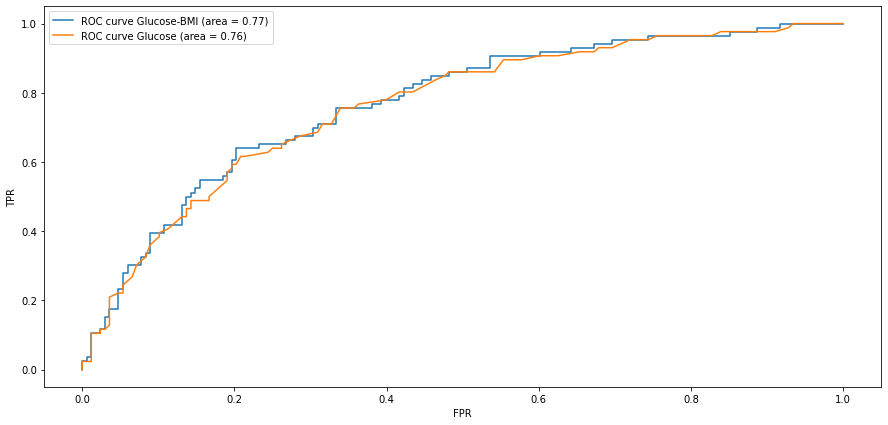

In [30]:
plt.figure(figsize=(15,7))
plt.plot(fpr_bv,tpr_bv, label='ROC curve '+"Glucose-BMI"+' (area = %0.2f)' %  auc_bv)
plt.plot(fpr_uv,tpr_uv, label='ROC curve '+"Glucose"+' (area = %0.2f)' %  auc_uv)
plot_figure()

# 

We can see both ROC curves looks very similar and it is difficult to choose one based only with the graphic. <br>
However, we can compare AUC values of each classifier. AUC represents the probability that a classifier will rank or score a randomly chosen positive instance higher than a negative. Close the AUC value to 1 better its the classifier, so we choose the one which have a higher value, for this specific context we can say Bivariate Model with Glucose-BMI is better than Univariate Model Glucose only by 0.01.

![](photos/3.1.png)

In [31]:
plt.rcParams["figure.figsize"] = (15,7)

In [32]:
def simple_discriminant(sigma,mu,pi,x):
    k=2
    invSigma = 1/sigma
    score = np.zeros(k)
    for label in range(k):
            muVec = np.reshape(mu[label,:],(2,1))
            trainx = np.reshape(x,(2,1))
            g = np.dot(invSigma*muVec.T,trainx) - 0.5*np.dot(invSigma*muVec.T,muVec)+pi[label]
            score[label] = g
            predictions = ((score[1]-score[0]) > 0).astype("int")
    if predictions == 0:
        return -1
    if predictions == 1:
        return 1
    

In [33]:
def paramLine():
    features = ["Glucose","BMI"]
    
    x = x_test[features]
    y = y_test
    
    mu = mu_bv
    pi = pi_bv
    sigma = sigma_bv
    
    x1min = min(x["Glucose"].values)-10
    x1max = max(x["Glucose"].values)+10
    x2min = min(x["BMI"].values)-10
    x2max = max(x["BMI"].values)+10
    
    x1 = np.linspace(x1min, x1max, 500,endpoint=True)
    x2 = np.linspace(x2min, x2max, 500,endpoint=True)
    
    
    Z=np.zeros((x1.shape[0],x1.shape[0]))
    mVec1=mu_bv[1]
    mVec0=mu_bv[0]
    invSigma=1/sigma_bv
    
    for i in range(len(x1)):
        for j in range(len(x2)):
            g1=np.matmul(invSigma*mVec1.T,np.array([[x1[i]],[x2[j]]]))-0.5*np.matmul(invSigma*mVec1.T,mVec1)+pi_bv[1]
            g0=np.matmul(invSigma*mVec0.T,np.array([[x1[i]],[x2[j]]]))-0.5*np.matmul(invSigma*mVec0.T,mVec0)+pi_bv[0]
            Z[j,i]=g1-g0
    
    Z[Z > 0] = 1
    Z[Z <= 0] = -1
    X, Y = np.meshgrid(x1, x2)

    return X,Y,Z

X,Y,Z=paramLine()

change=False
ind1=-1;
ind2=-1;
for index,element in enumerate(Z[499]):
    if(element != Z[499][index-1] and change==False and index>0):
        change=True
        ind1=index-1
        ind2=index


change=False
inde1=-1;
inde2=-1;
for inde,element in enumerate(Z[0]):
    if(element != Z[0][inde-1] and change==False and inde>0):
        change=True
        inde1=inde-1
        inde2=inde

#y=mx+b
pendiente1=(Y[499][ind1]-Y[0][inde1])/(X[499][ind1]-X[0][inde1])
b1_1=Y[499][ind1]- (X[499][ind1]*pendiente1)
b1_2=Y[0][inde1]- (X[0][inde1]*pendiente1)
print('The equation is y= mx * b =('+str(pendiente1)+'*x)+('+str(b1_1)+')')


The equation is y= mx * b =(-6.348370638578005*x)+(878.9627221856474)


In [34]:
def plot_test(f1,f2,sigma):
    global x1min,x1max
    features = [f1,f2]
    
    x = x_test[features]
    y = y_test
    
    mu = mu_bv
    pi = pi_bv
    sigma = sigma_bv
    
    x1min = min(x["Glucose"].values)-10
    x1max = max(x["Glucose"].values)+10
    x2min = min(x["BMI"].values)-10
    x2max = max(x["BMI"].values)+10
    #plt.figure(figsize = (15,7))
    
    plt.xlim(x1min,x1max)
    plt.ylim(x2min,x2max)
    plt.plot(x["Glucose"][y==1],x["BMI"][y==1], "ro")
    plt.plot(x["Glucose"][y==0],x["BMI"][y==0],"bP")
    
    grid_spacing = 0.5
    
    xx1,xx2 = np.meshgrid(np.arange(x1min,x1max,grid_spacing), np.arange(x2min,x2max,grid_spacing))
    grid = np.c_[xx1.ravel(),xx2.ravel()]
    
    Z = np.array([simple_discriminant(sigma,mu,pi,x) for x in grid])
    Z = Z.reshape(xx1.shape)
    

    plt.pcolormesh(xx1,xx2,Z, cmap = "coolwarm",vmin = -3, vmax=3)
    #plt.contour(xx1,xx2,Z,linewidths = 3,colors="blue")
    plt.xlabel(f1)
    plt.ylabel(f2)
    
    plt.title("Decision Boundaries")
    
    plt.show()

    

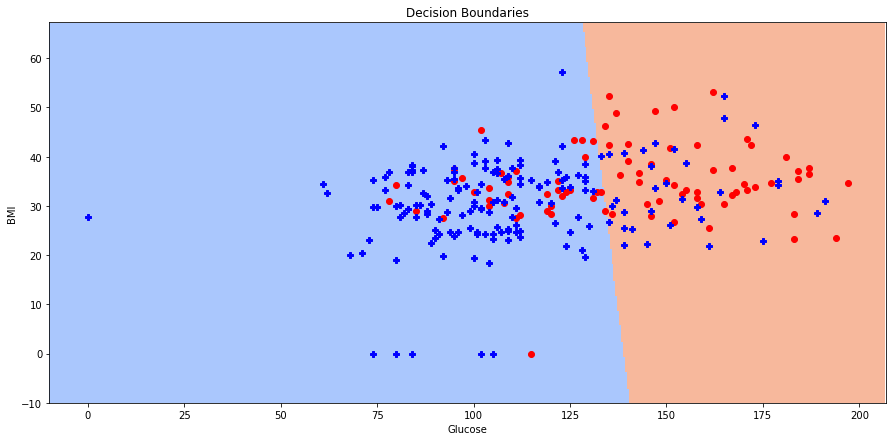

In [35]:
plot_test("Glucose","BMI", sigma_bv)

![](photos/3.2.png)
![](photos/3.a.png)


In [36]:
def boundary_line(mu_p, sigma_p, pi_p): 
    a = mu_p[1,0]-mu_p[0,0]
    b = mu_p[1,1]-mu_p[0,1]
    c = sigma_p*np.log(pi_p[0]/pi_p[1])+0.5*np.dot(mu_p[1,:]-mu_p[0,:],mu_p[1,:]+mu_p[0,:])

    return a, b, c

In [37]:
def plot_line(f1, f2, sigma,mu,pi,plot_test, model_p = 'model MLE'):
        a, b, c = boundary_line(mu_bv, sigma_bv, pi_bv)
        print(a,b,c)
        x = np.linspace(x1min, x1max, num = 50)
        y = pendiente1*x+b1_1
        plt.plot(x,y,linewidth=3.0, color = "k")
        plot_test(f1,f2,sigma)
        

32.64967562557925 5.171885343572086 4798.128208297247


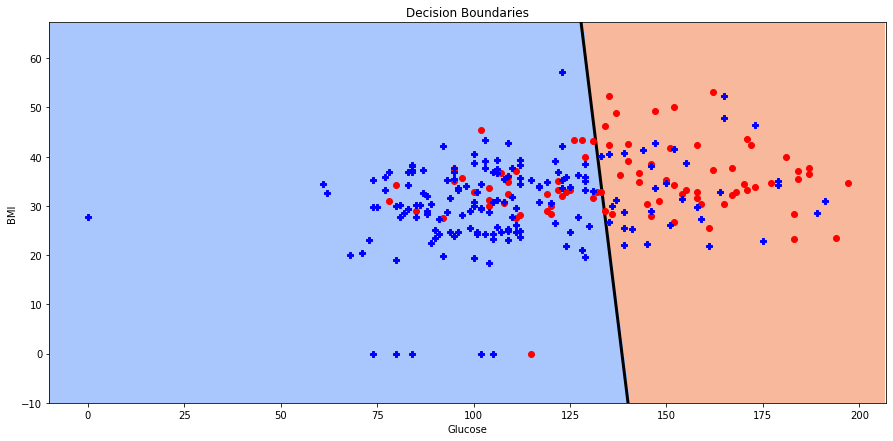

In [38]:
plot_line("Glucose","BMI",sigma_bv,mu_bv,pi_bv,plot_test)

![](photos/4.1.png)

In [39]:
def risk_classificator(mean,sigma,pi):
    # Calculamos la maxima likelihood de los datos
    c_0 = np.array(multivariate_normal.pdf(x_test[["Glucose","BMI"]], mean=mean[0], cov = np.sum(sigma),allow_singular=True)*pi[0])
    c_1 = np.array(multivariate_normal.pdf(x_test[["Glucose","BMI"]], mean=mean[1], cov = np.sum(sigma),allow_singular=True)*pi[1])
    
    df = pd.merge(x_test[['Glucose', 'BMI']], y_test,left_index=True, right_index=True ,how="inner")
    df['c_0'] = c_0
    df['c_1'] = c_1
    predicted = (c_0 < 2*c_1).astype("int")
    df["predict"] = predicted

    score_risk = []
    for i in range(len(c_0)):
        scores = [2*c_1,c_0]
        score_risk.append(scores)
    
    TP, TN, FP, FN, N = get_indicators(df) 
    return TP,TN,FP,FN,N,score_risk
    
    

In [40]:
TP,TN,FP,FN,N,scores = risk_classificator(mu_bv,sigma_bv,pi_bv)
print(f"accuracy risk = {((TP+TN)/N)} , accuracy without risk {accuracy_table['Glucose']['BMI']} ")
    

accuracy risk = 0.7007874015748031 , accuracy without risk 0.7509727626459144 


We observe that the model with risk has a lower performance than the model without risk because of the risk actions we can shoose a class even with the probability 
is more because the cost of false negative is less than the false positive.

![](photos/4.2.png)

In [41]:
nt_risk = len(y_test)
score_risk = np.reshape(np.array(scores)[0,:,:].T,(254,2))

In [42]:
score_p_risk = score_risk/score_risk.sum(axis=1).reshape((nt_risk,1))

In [43]:
fpr,tpr,_ = roc_curve(y_test,score_p_risk[:,0])
roc_auc = auc(fpr, tpr)
roc_auc

0.7674418604651163

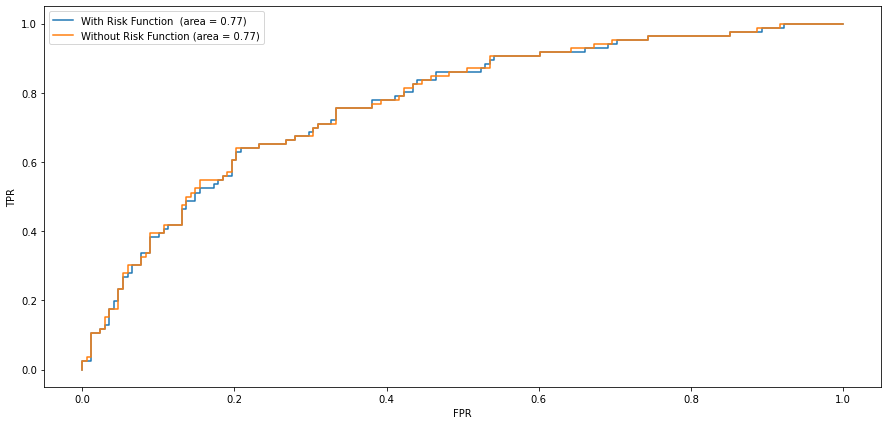

In [44]:
plt.plot(fpr,tpr, label='With Risk Function '+' (area = %0.2f)' %  roc_auc)
plt.plot(fpr_bv,tpr_bv, label='Without Risk Function '+'(area = %0.2f)' %  auc_bv)
plot_figure()

We can see ROC Curves are similar to both cases, choose one above the other is difficult in this situation, but in this model we have a lower rate of flase positive due to the value of $\lambda_{01}$